# HW4


### Part 2
Go around the entire loop of 6 images and set up the problem by outputting vertices and edges in the g2o format as use obtain "odometry" readings by matching images sequentially. That is match image pairs 1-2, 2-3, 3-4, 4-5, 5-6, and finally 6-1.

Justify your choice of the covariance (and thus information) matrix that you use for each edge. Once you have completed the loop run g2o on the output vertices and edges and see how that 

#### (a) Affects the location of individual image centers - your "odometry"

#### (b) The covariances for each measurement


### Part 3
Now repeat part 2 with the additional edges that you can compute for any of the crosslinks between images 1-5, 2-5, 2-4, 3-5, 2-6.


### Part 4. Now go to the set of 29 images.

#### (a) Repeat part 2 for this image set.  

#### (b) Repeat part 3 for this image set (you need a nice mechanism for storing possible crosslinks). 


### Part 5 (optional!)
do 4(a) and (b) for all images in the dataset!

In [1]:
from matplotlib import pyplot as plt
from scipy import spatial
import numpy as np
import glob
import math
import cv2
import itertools

# import custom libraries
import vikrant_functions
import hw4_functions

## Functions to stitch images together
Some of these are adapted from hw2/hw3, as they are solving a similar problem

In [2]:
# returns the x,y coordinates of the corners of an image
def find_corners(img):
    corner_points = np.matrix([[0,0],[0,img.shape[0]],[img.shape[1],img.shape[0]],[img.shape[1],0]])
    return corner_points

# creates a shifting transformation from offset (x,y)
def create_offset_matrix(offset):
    offset_matrix = np.concatenate((np.identity(2), np.transpose(offset)), axis=1)        
    offset_matrix = np.concatenate((offset_matrix, np.matrix([0,0,1])), axis=0)
    return offset_matrix

#warps im_src into im_dst, returning im_final
def add_image(im_src, im_dst):
    # estimate homography with detected features
    try:
        # previously: distance_constant = 0.85, minimum_matches=55
        (src_pts, dst_pts) = hw4_functions.match_features(im_src, im_dst, minimum_matches=55, distance_constant = 0.85)

        print("matching points: ", len(src_pts))
    except AssertionError:
        raise AssertionError("Not enough reliable matches")
    else:
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        return H, len(src_pts)

### Import Images

In [3]:
# import panorama images
images = [cv2.imread(file) 
               for file in glob.glob("image_subset/*.tif")]
num_images = len(images)
assert num_images > 1, "Too few images to calculate homography"

all_images = [cv2.imread(file) 
               for file in glob.glob("picture set/all_columns/*.tif")]

# uncomment to show images
# for index in range(num_images):
#     plt.imshow(images[index]), plt.title('image' + str(index)), plt.show()

## Functions

In [4]:
# each homography in reference of the first image's coordinate frame
# each homography is originally between sequential image frames
def calculate_relative_homographies(H_list):
    num_homographies = len(H_list)
    H_sequential_list = [H_list[0]] # start with the first homography
    
    for index in range(num_homographies):
        if ( index + 1 < num_homographies ):
            # keep multiplying onto the last element
            new_homography = np.matmul(H_list[index+1], H_sequential_list[-1])
            H_sequential_list.append(new_homography)
            
    return H_sequential_list

# combines two images according to a homography
def stitch_sequentially(homography, images):
    # find all final (warped) image corner locations
    image_corners = find_corners(images[0]).transpose()
    image_corners = np.vstack([image_corners, np.ones(4)])
    origin = np.array([[0],[0],[1]])
    # find all new corner points            
    new_corners = np.matmul(homography, image_corners) # maybe need to normalize? (ignoring for now)  
    # find the minimum and maximum corner locations in x and y
    points = np.concatenate([origin, image_corners, new_corners], axis=1)
    min_point = np.amin(points, axis=1)
    max_point = np.amax(points, axis=1)
        
    min_xy = min_point[:2,]    
    offset_matrix = create_offset_matrix(offset = -min_xy.T)
    homography = np.matmul(offset_matrix, homography)

    # calculate size of final image
    final_img_size = np.subtract(max_point, min_point)
    final_img_size_tuple = (int(final_img_size[0]), int(final_img_size[1]))
    
    # combine all images together
    # shift destination image
    final_img = cv2.warpPerspective(images[0], offset_matrix, final_img_size_tuple)
           
    # warp and shift new image
    img_warped = cv2.warpPerspective(images[1], homography, final_img_size_tuple)
    # add new warped image to final_img
    final_img = cv2.addWeighted(img_warped, 0.5, final_img, 0.5, -1)
        
    return final_img
    
# plot new image centers after applying homographies
def plot_centers(H_list, midpoint):
    H_list_relative = calculate_relative_homographies(H_list)
    midpoint = np.array(midpoint)[np.newaxis].T
    midpoint = np.vstack((midpoint,1))
    new_points = np.zeros((3, len(H_list)+1))
    new_points[:,0] = midpoint[:,0] # first image at original midpoint
    for index in range(len(H_list)):
        warped_point = np.matmul(H_list_relative[index], midpoint)
        new_points[:,index+1] = warped_point.reshape(3)
    new_points = np.subtract(new_points, midpoint) # offset midpoint to 0,0
    
    plt.figure()
    points, = plt.plot(new_points[0,:], new_points[1,:], '*-', label='points')
    start_point, = plt.plot(new_points[0,0], new_points[1,0], 'g*', label='start')
    end_point, = plt.plot(new_points[0,-1], new_points[1,-1], 'r*', label='end')
    plt.xlabel('pixels'), plt.ylabel('pixels')
    plt.gca().invert_yaxis() # using image coordinates
    plt.title('Image centers (from sequential homographies)')
    plt.legend(handles=[start_point, end_point])
    plt.show()
    
    return new_points

# ensure that the rotation matrix within homography H is orthogonal
def get_corrected_rotation_matrix(H):
    R = H[0:2,0:2]
    U,S,V = np.linalg.svd(R)
    R_corr = U@V
    return R_corr

# returns homography between images and plots the combined result
# images: list of images
# image_indexes: list of indexes of images to compare in images list
def match_by_index(images, image_indexes):
    title_str = str(image_indexes[0]) + ' and ' + str(image_indexes[1])
    try:
        H_new, num_matches = add_image(images[image_indexes[1]], images[image_indexes[0]])
           
        # testing: just using change in x,y,theta
        delta_x = H_new[0,2]
        delta_y = H_new[1,2]
        R_corr = get_corrected_rotation_matrix( H_new ) # ensure that RT' = I
        delta_theta = math.atan2(-R_corr[0,1], R_corr[0,0])
        
        H_test = np.array([[np.cos(delta_theta), -np.sin(delta_theta), delta_x],
                          [np.sin(delta_theta), np.cos(delta_theta), delta_y],
                          [0,0,1]])
        test = stitch_sequentially(H_test, [images[image_indexes[0]],images[image_indexes[1]]])
#         Uncomment to display images
#         plt.imshow(test), plt.title(title_str + " (rotation + translation only)"), plt.show()
        
        return H_new
    except AssertionError:
        raise AssertionError("Not enough matches for " + title_str)

# calculates dx, dy, dtheta, and information matrix from a homography
def translation_from_homography( H ):
        cov_constant = 0.02
    
        delta_x = H[0,2]
        delta_y = H[1,2]
        R_corr = get_corrected_rotation_matrix( H ) # ensure that RT' = I
        delta_theta = math.atan2(-R_corr[0,1], R_corr[0,0])

        cov_matrix = np.array([[delta_x,0,0],[0,delta_y,0],[0,0,delta_theta]])
        cov_matrix = cov_constant*np.abs(cov_matrix) # scale and make sure elements positive
        info_matrix = np.linalg.inv(cov_matrix)
        
        return delta_x, delta_y, delta_theta, info_matrix

### Part 1
Modify your registration module from the previous home works to allow you to robustly match features across two images. To check for robustness see if you can use the 6 image dataset to match 

#### (a) the 6 images in a loop

# Calculate homography between sequential images

### Homographies between sequential images for image subset

images 0 and 1
matching points:  335
images 1 and 2
matching points:  327
images 2 and 3
matching points:  109
images 3 and 4
matching points:  303
images 4 and 5
matching points:  328
images 5 and 6


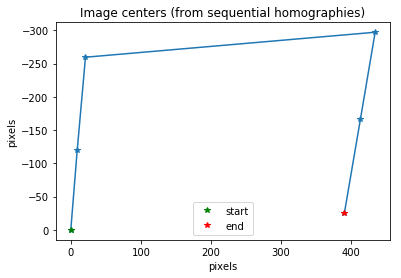

In [5]:
H_list = []
num_images = len(images)
for index in range(num_images):
    print("images", index, "and", index+1)
    if ( index + 1 < num_images ):
        try:
            H_new = match_by_index(images, image_indexes=[index,index+1])
            H_list.append( H_new )
        except AssertionError:
            pass
        
midpoint = [int(images[0].shape[0]/2), int(images[1].shape[0]/2)]
_ = plot_centers(H_list=H_list, midpoint=midpoint)

### Homography between all sequential images

In [6]:
H_list_all = []
num_all_images = len(all_images)
for index in range(num_all_images):
    print("images", index, "and", index+1)
    if ( index + 1 < num_all_images ):
        try:
            H_new = match_by_index(all_images, image_indexes=[index,index+1])
            H_list_all.append( H_new )
        except AssertionError:
            pass

images 0 and 1
matching points:  337
images 1 and 2
matching points:  243
images 2 and 3
matching points:  230
images 3 and 4
matching points:  308
images 4 and 5
matching points:  174
images 5 and 6
matching points:  223
images 6 and 7
matching points:  146
images 7 and 8
matching points:  395
images 8 and 9
matching points:  414
images 9 and 10
matching points:  372
images 10 and 11
matching points:  340
images 11 and 12
matching points:  337
images 12 and 13
matching points:  341
images 13 and 14
matching points:  111
images 14 and 15
matching points:  301
images 15 and 16
matching points:  312
images 16 and 17
matching points:  459
images 17 and 18
matching points:  405
images 18 and 19
matching points:  441
images 19 and 20
matching points:  430
images 20 and 21
matching points:  302
images 21 and 22
matching points:  370
images 22 and 23
matching points:  429
images 23 and 24
matching points:  331
images 24 and 25
matching points:  362
images 25 and 26
matching points:  364
image

### Find homographies between cross-links
Commented here, because it takes a long time to run. This was found earlier and is stored in 'combinations'.

In [7]:
# # loop through cross-links in image subset
# image_index_list = range(len(images))
# combinations = itertools.combinations(image_index_list,2)
# H_edge_list = [] # list of homographies between non-sequential matches
# edge_index_list = [] # list of indexes corresponding to H_list_edges
# for item in combinations:
#     if ( abs(item[1]-item[0]) == 1 ): # skip sequential indices
#         pass
#     else:
#         try:
#             H_edge = match_by_index(images, image_indexes=[item[0],item[1]])
#             H_edge_list.append( H_edge )
#             edge_index_list.append( item )
#         except AssertionError:
#             pass

# # loop through cross-links for all images
# # (this takes a long time, so I just ran it once and saved the result)
# image_index_list = range(len(all_images))
# combinations = itertools.combinations(image_index_list,2)

In [8]:
# calculated earlier (via trying all combinations of non-sequential images)
combinations = [ (0,2), (0,12), (0,13), (1,11), (1,12), (1,13), (2,9), (2,11), (2,12), (3,9), (3,10), (3,11), (4,7), (4,8), (4,9), (5,7), (5,8), (7,9), (8,10), (9,17), (10,16), (10,17), (11,13), (12,15), (14,16), (14,26), (14,27), (14,28), (15,17), (15,25), (15,26), (15,27), (15,28), (16,18), (16,25), (16,26), (16,27), (17,19), (17,23), (17,24), (17,25), (17,26), (18,20), (18,22), (18,23), (18,24), (18,25), (19,21), (19,22), (19,23), (19,24), (20,22), (20,23), (24,26) ]
H_edge_list = [] # list of homographies between non-sequential matches
edge_index_list = [] # list of indexes corresponding to H_list_edges
for item in combinations:
    if ( abs(item[1]-item[0]) == 1 ): # skip sequential indices
        pass
    else:
        try:
            print("trying ", item[0], "and", item[1])
            H_edge = match_by_index(all_images, image_indexes=[item[0],item[1]])
            H_edge_list.append( H_edge )
            edge_index_list.append( item )
        except AssertionError:
            pass

trying  0 and 2
matching points:  150
trying  0 and 12
matching points:  137
trying  0 and 13
matching points:  169
trying  1 and 11
matching points:  143
trying  1 and 12
matching points:  170
trying  1 and 13
matching points:  122
trying  2 and 9
matching points:  163
trying  2 and 11
matching points:  209
trying  2 and 12
matching points:  152
trying  3 and 9
matching points:  192
trying  3 and 10
matching points:  199
trying  3 and 11
matching points:  160
trying  4 and 7
matching points:  131
trying  4 and 8
matching points:  180
trying  4 and 9
matching points:  247
trying  5 and 7
matching points:  188
trying  5 and 8
matching points:  169
trying  7 and 9
matching points:  181
trying  8 and 10
matching points:  185
trying  9 and 17
matching points:  166
trying  10 and 16
matching points:  165
trying  10 and 17
matching points:  165
trying  11 and 13
matching points:  144
trying  12 and 15
matching points:  151
trying  14 and 16
matching points:  147
trying  14 and 26
matching po

### Generate g2o Input File
Here, we use the list of sequential homographies to generate pose in $(x,y,\theta)$ for edges and vertices.

In [9]:
delta_x = []
delta_y = []
delta_theta = []
x = [0]
y = [0]
theta = [0]
info_matrix = []
cov_matrix = []
image_index_list = []

H_list = H_list_all # use for larger dataset

# for H in H_list:
for index in range( len(H_list) ):
    dx, dy, dt, current_info_matrix = translation_from_homography( H_list[index] )
    # add edges to list (change in pose and information matrix)
    delta_x.append( dx )
    delta_y.append( dy )
    delta_theta.append( dt )
    info_matrix.append( current_info_matrix )
    image_index_list.append( (index, index+1) )

    # calculate vertexes based on change in pose
    x.append( x[-1] + dx )
    y.append( y[-1] + dy )
    theta.append( theta[-1] + dt )
    
# add edge information from non-sequential images
for H in H_edge_list:
    dx, dy, dt, current_info_matrix = translation_from_homography( H )
    
    # add change in pose to list
    delta_x.append( dx )
    delta_y.append( dy )
    delta_theta.append( dt )
    info_matrix.append( current_info_matrix )

# add on matching indexes to edge index list
image_index_list= image_index_list + edge_index_list

# write vertices and edges to file
g2o_input = open('g2o_input/input05.g2o','w')

for index in range( len(delta_x) ): # edges from sequential images
    edge_str = "EDGE_SE2 " + str( image_index_list[index][0] ) + " " + str( image_index_list[index][1] ) + " " + \
        str( delta_x[index] ) + " " + str( delta_y[index] ) + " " + str( delta_theta[index] ) + " " + \
        str( info_matrix[index-1][0,0] ) + " 0 0 " + str( info_matrix[index-1][1,1] ) + " 0 " + \
        str( info_matrix[index-1][2,2] ) + "\n"
    g2o_input.write( edge_str )
for index in range(len(x)): # vertices
    vertex_str = "VERTEX_SE2 " + str( index ) + " " + str( x[index] ) + " " + str( y[index] ) + " " + \
        str( theta[index] ) + "\n"
    g2o_input.write( vertex_str )
    
g2o_input.close()

### Visualize g2o output file

In [10]:
# # import the g2o file (calculated separately from this script)
# # g2o_file = open('g2o_output/output08.g2o','r')
# g2o_file = open('g2o_input/input04.g2o','r')

# lines = g2o_file.readlines()
# g2o_file.close()
# x_vertex = []
# y_vertex = []
# x_edge = [0]
# y_edge = [0]
# theta_edge = [0]
# for line in lines:
#     list = line.split(" ")
#     if 'VERTEX_SE2' in line: # these don't match for whatever reason
#         x_vertex.append( float(list[2]) )
#         y_vertex.append( float(list[3]) )
# # for line in lines:
#     if 'EDGE_SE2' in line:
#         x_edge.append( x_edge[-1] + float( list[3]) )
#         y_edge.append( y_edge[-1] + float(list[4]) )
#         theta_edge.append( theta_edge[-1] + float(list[5]) )

# # plot results (before and after g2o on loop closure)
# plt.figure()
# old_points, = plt.plot(np.array(x), np.array(y), 'r*-', label='original points')
# edge_points, = plt.plot(x_edge, y_edge, 'b*-', label='after g2o (from edges)')
# vertex_points, = plt.plot(x_vertex, y_vertex, 'g*-', label='after g2o (from vertexes)')
# plt.xlabel('pixels'), plt.ylabel('pixels')
# plt.gca().invert_yaxis() # using image coordinates
# plt.gca().set_aspect('equal', 'datalim')
# plt.title('Image centers after g2o')
# plt.legend(handles=[old_points, edge_points, vertex_points])
# plt.show()

## Before and After g2o
### Image Subset
<img src="figures/Pose_plot_6.png">

### All 29 Images
<img src="figures/Pose_plot_29.png">

## Stitched Images
### Before
<img src="figures/BeforeOpt.png">

### After
<img src="figures/AfterOpt.png">